# Water Level Prediction using LSTM

This notebook implements a complex LSTM model to predict water levels using both hourly and daily datasets.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 2. Load and Explore Datasets

In [2]:
# Load hourly data
df_hourly = pd.read_csv('full_merged.csv')
df_hourly['measure_datetime'] = pd.to_datetime(df_hourly['measure_datetime'])
df_hourly.set_index('measure_datetime', inplace=True)

# Load daily data
df_daily = pd.read_csv('full_merged_daily.csv')
df_daily['measure_datetime'] = pd.to_datetime(df_daily['measure_datetime'])
df_daily.set_index('measure_datetime', inplace=True)

print("Hourly Data Shape:", df_hourly.shape)
print("\nHourly Data Info:")
print(df_hourly.info())
print("\nHourly Data Statistics:")
print(df_hourly.describe())
print("\n" + "="*80 + "\n")
print("Daily Data Shape:", df_daily.shape)
print("\nDaily Data Info:")
print(df_daily.info())
print("\nDaily Data Statistics:")
print(df_daily.describe())

Hourly Data Shape: (56232, 16)

Hourly Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 56232 entries, 2019-01-01 00:00:00 to 2025-05-31 23:00:00
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   water_level                 56232 non-null  float64
 1   temperature_2m              56232 non-null  float64
 2   rain                        56232 non-null  float64
 3   showers                     56232 non-null  float64
 4   cloud_cover                 56232 non-null  int64  
 5   relative_humidity_2m        56232 non-null  int64  
 6   dew_point_2m                56232 non-null  float64
 7   precipitation               56232 non-null  float64
 8   weather_code                56232 non-null  int64  
 9   pressure_msl                56232 non-null  float64
 10  surface_pressure            56232 non-null  float64
 11  wind_speed_10m              56232 non-null  float64
 12  win

Missing values in Hourly Data:
water_level                   0
temperature_2m                0
rain                          0
showers                       0
cloud_cover                   0
relative_humidity_2m          0
dew_point_2m                  0
precipitation                 0
weather_code                  0
pressure_msl                  0
surface_pressure              0
wind_speed_10m                0
wind_direction_10m            0
wind_gusts_10m                0
et0_fao_evapotranspiration    0
river_discharge               0
dtype: int64

Missing values in Daily Data:
water_level                   0
temperature_2m                0
rain                          0
showers                       0
cloud_cover                   0
relative_humidity_2m          0
dew_point_2m                  0
precipitation                 0
weather_code                  0
pressure_msl                  0
surface_pressure              0
wind_speed_10m                0
wind_direction_10m           

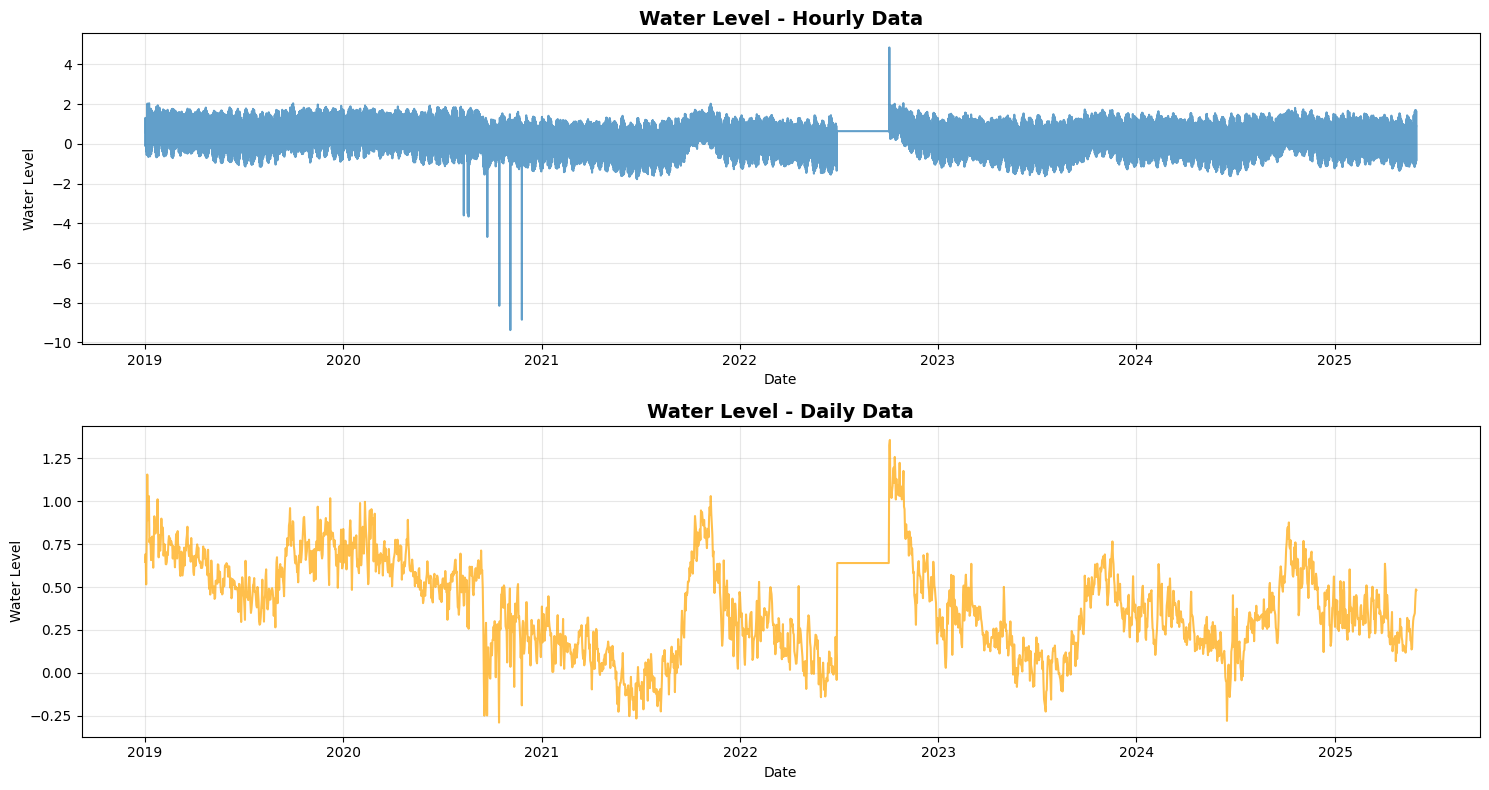

In [3]:
# Check for missing values
print("Missing values in Hourly Data:")
print(df_hourly.isnull().sum())
print("\nMissing values in Daily Data:")
print(df_daily.isnull().sum())

# Visualize water level trends
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(df_hourly.index, df_hourly['water_level'], alpha=0.7)
axes[0].set_title('Water Level - Hourly Data', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Water Level')
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_daily.index, df_daily['water_level'], alpha=0.7, color='orange')
axes[1].set_title('Water Level - Daily Data', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Water Level')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Create Custom Dataset Class for LSTM

In [4]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, target_col='water_level', seq_length=24, forecast_horizon=1):
        """
        Args:
            data: DataFrame with features
            target_col: Name of the target column
            seq_length: Number of time steps to look back
            forecast_horizon: Number of time steps to predict ahead
        """
        self.data = data.copy()
        self.target_col = target_col
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        
        # Separate features and target
        self.feature_cols = [col for col in data.columns if col != target_col]
        
        # Scale features and target
        self.feature_scaler = StandardScaler()
        self.target_scaler = MinMaxScaler()
        
        self.features = self.feature_scaler.fit_transform(data[self.feature_cols].values)
        self.target = self.target_scaler.fit_transform(data[[target_col]].values)
        
        # Create sequences
        self.X, self.y = self._create_sequences()
        
    def _create_sequences(self):
        X, y = [], []
        for i in range(len(self.features) - self.seq_length - self.forecast_horizon + 1):
            X.append(self.features[i:i+self.seq_length])
            y.append(self.target[i+self.seq_length:i+self.seq_length+self.forecast_horizon])
        return np.array(X), np.array(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])
    
    def inverse_transform_target(self, y):
        """Inverse transform the scaled target values"""
        return self.target_scaler.inverse_transform(y)

## 4. Define Complex LSTM Architecture

In [5]:
class ComplexLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], num_layers=3, 
                 dropout=0.2, forecast_horizon=1, bidirectional=True):
        """
        Complex LSTM with multiple layers, bidirectional processing, and attention
        
        Args:
            input_size: Number of input features
            hidden_sizes: List of hidden layer sizes
            num_layers: Number of LSTM layers per block
            dropout: Dropout rate
            forecast_horizon: Number of steps to forecast
            bidirectional: Whether to use bidirectional LSTM
        """
        super(ComplexLSTM, self).__init__()
        
        self.hidden_sizes = hidden_sizes
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.forecast_horizon = forecast_horizon
        self.num_directions = 2 if bidirectional else 1
        
        # First LSTM block
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_sizes[0],
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Second LSTM block
        self.lstm2 = nn.LSTM(
            input_size=hidden_sizes[0] * self.num_directions,
            hidden_size=hidden_sizes[1],
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Third LSTM block
        self.lstm3 = nn.LSTM(
            input_size=hidden_sizes[1] * self.num_directions,
            hidden_size=hidden_sizes[2],
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Attention mechanism
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_sizes[2] * self.num_directions,
            num_heads=4,
            dropout=dropout,
            batch_first=True
        )
        
        # Batch normalization
        self.batch_norm1 = nn.BatchNorm1d(hidden_sizes[0] * self.num_directions)
        self.batch_norm2 = nn.BatchNorm1d(hidden_sizes[1] * self.num_directions)
        self.batch_norm3 = nn.BatchNorm1d(hidden_sizes[2] * self.num_directions)
        
        # Dropout layers
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)
        
        # Fully connected layers
        fc_input_size = hidden_sizes[2] * self.num_directions
        self.fc1 = nn.Linear(fc_input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, forecast_horizon)
        
        # Activation
        self.relu = nn.ReLU()
        self.dropout_fc = nn.Dropout(dropout)
        
    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        
        # First LSTM block
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = lstm1_out.transpose(1, 2)
        lstm1_out = self.batch_norm1(lstm1_out)
        lstm1_out = lstm1_out.transpose(1, 2)
        lstm1_out = self.dropout1(lstm1_out)
        
        # Second LSTM block
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = lstm2_out.transpose(1, 2)
        lstm2_out = self.batch_norm2(lstm2_out)
        lstm2_out = lstm2_out.transpose(1, 2)
        lstm2_out = self.dropout2(lstm2_out)
        
        # Third LSTM block
        lstm3_out, _ = self.lstm3(lstm2_out)
        lstm3_out = lstm3_out.transpose(1, 2)
        lstm3_out = self.batch_norm3(lstm3_out)
        lstm3_out = lstm3_out.transpose(1, 2)
        lstm3_out = self.dropout3(lstm3_out)
        
        # Attention mechanism
        attn_out, _ = self.attention(lstm3_out, lstm3_out, lstm3_out)
        
        # Use the last output from attention
        final_hidden = attn_out[:, -1, :]
        
        # Fully connected layers
        out = self.relu(self.fc1(final_hidden))
        out = self.dropout_fc(out)
        out = self.relu(self.fc2(out))
        out = self.dropout_fc(out)
        out = self.fc3(out)
        
        return out.unsqueeze(-1)  # Add dimension for consistency

## 5. Training and Evaluation Functions

In [6]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    for X_batch, y_batch in dataloader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)


def validate(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            total_loss += loss.item()
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    predictions = np.concatenate(all_predictions, axis=0)
    targets = np.concatenate(all_targets, axis=0)
    
    return avg_loss, predictions, targets


def train_model(model, train_loader, val_loader, criterion, optimizer, 
                scheduler, num_epochs, device, patience=10):
    """Train the model with early stopping"""
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Train
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # Validate
        val_loss, _, _ = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        if scheduler is not None:
            scheduler.step(val_loss)
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.6f}, '
                  f'Val Loss: {val_loss:.6f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.6f}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return train_losses, val_losses


def calculate_metrics(y_true, y_pred):
    """Calculate evaluation metrics"""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }

## 6. Experiment 1: Hourly Data (full_merged.csv)

### 6.1 Prepare Data

In [7]:
# Hyperparameters for hourly data
SEQ_LENGTH_HOURLY = 48  # Look back 48 hours (2 days)
FORECAST_HORIZON = 1     # Predict next hour
BATCH_SIZE_HOURLY = 64
NUM_EPOCHS_HOURLY = 100
LEARNING_RATE = 0.001

# Handle missing values
df_hourly_clean = df_hourly.fillna(method='ffill').fillna(method='bfill')

# Split data: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(df_hourly_clean))
val_size = int(0.15 * len(df_hourly_clean))

train_data_hourly = df_hourly_clean[:train_size]
val_data_hourly = df_hourly_clean[train_size:train_size+val_size]
test_data_hourly = df_hourly_clean[train_size+val_size:]

print(f"Training samples: {len(train_data_hourly)}")
print(f"Validation samples: {len(val_data_hourly)}")
print(f"Test samples: {len(test_data_hourly)}")

# Create datasets
train_dataset_hourly = TimeSeriesDataset(
    train_data_hourly, 
    seq_length=SEQ_LENGTH_HOURLY, 
    forecast_horizon=FORECAST_HORIZON
)
val_dataset_hourly = TimeSeriesDataset(
    val_data_hourly, 
    seq_length=SEQ_LENGTH_HOURLY, 
    forecast_horizon=FORECAST_HORIZON
)
test_dataset_hourly = TimeSeriesDataset(
    test_data_hourly, 
    seq_length=SEQ_LENGTH_HOURLY, 
    forecast_horizon=FORECAST_HORIZON
)

# Create data loaders
train_loader_hourly = DataLoader(train_dataset_hourly, batch_size=BATCH_SIZE_HOURLY, shuffle=True)
val_loader_hourly = DataLoader(val_dataset_hourly, batch_size=BATCH_SIZE_HOURLY, shuffle=False)
test_loader_hourly = DataLoader(test_dataset_hourly, batch_size=BATCH_SIZE_HOURLY, shuffle=False)

print(f"\nInput features: {len(train_dataset_hourly.feature_cols)}")
print(f"Sequence length: {SEQ_LENGTH_HOURLY}")
print(f"Forecast horizon: {FORECAST_HORIZON}")
print(f"Number of training batches: {len(train_loader_hourly)}")

Training samples: 39362
Validation samples: 8434
Test samples: 8436

Input features: 15
Sequence length: 48
Forecast horizon: 1
Number of training batches: 615


### 6.2 Initialize and Train Model

In [8]:
# Initialize model for hourly data
input_size_hourly = len(train_dataset_hourly.feature_cols)
model_hourly = ComplexLSTM(
    input_size=input_size_hourly,
    hidden_sizes=[128, 64, 32],
    num_layers=2,
    dropout=0.3,
    forecast_horizon=FORECAST_HORIZON,
    bidirectional=True
).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer_hourly = optim.Adam(model_hourly.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler_hourly = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_hourly, mode='min', factor=0.5, patience=5
)

# Print model summary
print(f"Model Architecture:")
print(model_hourly)
print(f"\nTotal parameters: {sum(p.numel() for p in model_hourly.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_hourly.parameters() if p.requires_grad):,}")

Model Architecture:
ComplexLSTM(
  (lstm1): LSTM(15, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm2): LSTM(256, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm3): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_fe

In [9]:
# Train the model
print("Training model on hourly data...")
print("="*80)
train_losses_hourly, val_losses_hourly = train_model(
    model_hourly, 
    train_loader_hourly, 
    val_loader_hourly, 
    criterion, 
    optimizer_hourly, 
    scheduler_hourly,
    num_epochs=NUM_EPOCHS_HOURLY,
    device=device,
    patience=15
)
print("="*80)
print("Training completed!")

Training model on hourly data...
Epoch [10/100], Train Loss: 0.001615, Val Loss: 0.050774, LR: 0.001000
Epoch [10/100], Train Loss: 0.001615, Val Loss: 0.050774, LR: 0.001000
Epoch [20/100], Train Loss: 0.001459, Val Loss: 0.049352, LR: 0.000250
Epoch [20/100], Train Loss: 0.001459, Val Loss: 0.049352, LR: 0.000250
Early stopping at epoch 21
Training completed!
Early stopping at epoch 21
Training completed!


### 6.3 Evaluate Model

In [10]:
# Evaluate on test set
_, test_predictions_hourly, test_targets_hourly = validate(
    model_hourly, test_loader_hourly, criterion, device
)

# Inverse transform predictions and targets
test_predictions_hourly_orig = test_dataset_hourly.inverse_transform_target(
    test_predictions_hourly.reshape(-1, 1)
)
test_targets_hourly_orig = test_dataset_hourly.inverse_transform_target(
    test_targets_hourly.reshape(-1, 1)
)

# Calculate metrics
metrics_hourly = calculate_metrics(test_targets_hourly_orig, test_predictions_hourly_orig)

print("\n" + "="*80)
print("HOURLY DATA - TEST SET PERFORMANCE")
print("="*80)
for metric, value in metrics_hourly.items():
    print(f"{metric}: {value:.6f}")
print("="*80)


HOURLY DATA - TEST SET PERFORMANCE
MSE: 0.541111
RMSE: 0.735602
MAE: 0.570119
R2: -0.185669


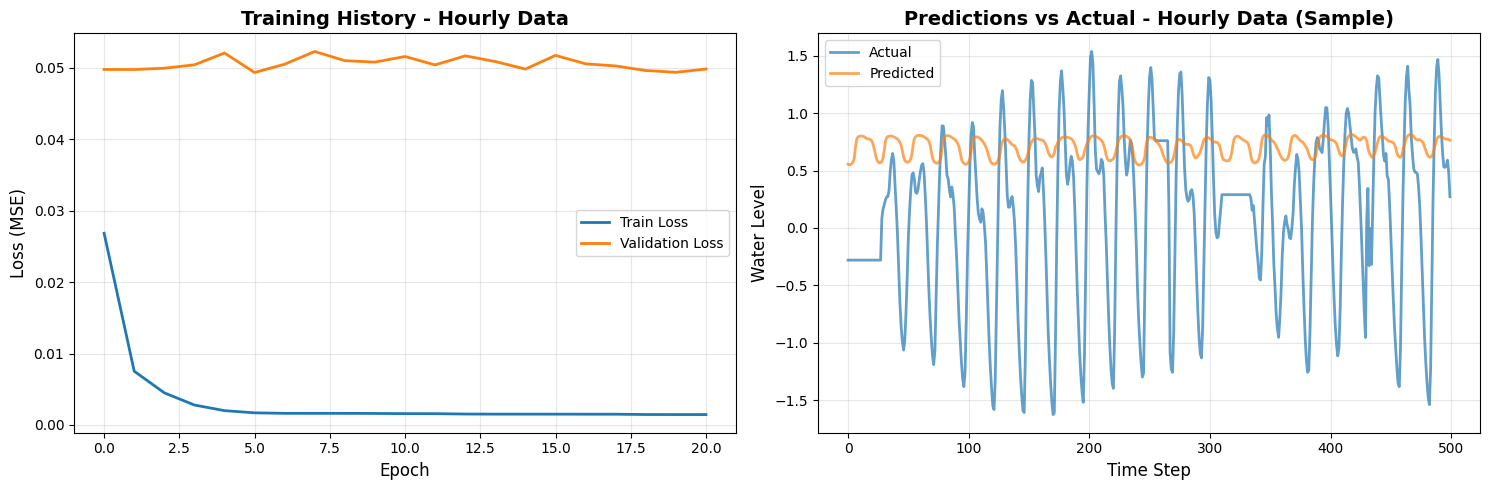

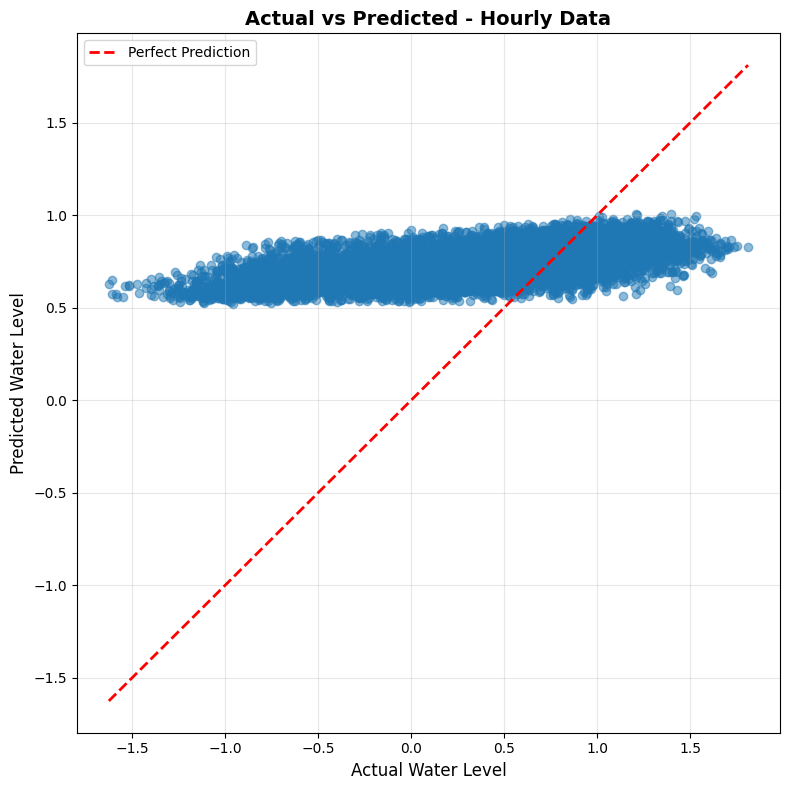

In [11]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses_hourly, label='Train Loss', linewidth=2)
axes[0].plot(val_losses_hourly, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training History - Hourly Data', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot predictions vs actual
sample_size = min(500, len(test_predictions_hourly_orig))
axes[1].plot(test_targets_hourly_orig[:sample_size], label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(test_predictions_hourly_orig[:sample_size], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Time Step', fontsize=12)
axes[1].set_ylabel('Water Level', fontsize=12)
axes[1].set_title('Predictions vs Actual - Hourly Data (Sample)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(test_targets_hourly_orig, test_predictions_hourly_orig, alpha=0.5)
plt.plot([test_targets_hourly_orig.min(), test_targets_hourly_orig.max()],
         [test_targets_hourly_orig.min(), test_targets_hourly_orig.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Water Level', fontsize=12)
plt.ylabel('Predicted Water Level', fontsize=12)
plt.title('Actual vs Predicted - Hourly Data', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Experiment 2: Daily Data (full_merged_daily.csv)

### 7.1 Prepare Data

In [12]:
# Hyperparameters for daily data
SEQ_LENGTH_DAILY = 30    # Look back 30 days
BATCH_SIZE_DAILY = 32
NUM_EPOCHS_DAILY = 100

# Handle missing values
df_daily_clean = df_daily.fillna(method='ffill').fillna(method='bfill')

# Split data: 70% train, 15% validation, 15% test
train_size_d = int(0.7 * len(df_daily_clean))
val_size_d = int(0.15 * len(df_daily_clean))

train_data_daily = df_daily_clean[:train_size_d]
val_data_daily = df_daily_clean[train_size_d:train_size_d+val_size_d]
test_data_daily = df_daily_clean[train_size_d+val_size_d:]

print(f"Training samples: {len(train_data_daily)}")
print(f"Validation samples: {len(val_data_daily)}")
print(f"Test samples: {len(test_data_daily)}")

# Create datasets
train_dataset_daily = TimeSeriesDataset(
    train_data_daily, 
    seq_length=SEQ_LENGTH_DAILY, 
    forecast_horizon=FORECAST_HORIZON
)
val_dataset_daily = TimeSeriesDataset(
    val_data_daily, 
    seq_length=SEQ_LENGTH_DAILY, 
    forecast_horizon=FORECAST_HORIZON
)
test_dataset_daily = TimeSeriesDataset(
    test_data_daily, 
    seq_length=SEQ_LENGTH_DAILY, 
    forecast_horizon=FORECAST_HORIZON
)

# Create data loaders
train_loader_daily = DataLoader(train_dataset_daily, batch_size=BATCH_SIZE_DAILY, shuffle=True)
val_loader_daily = DataLoader(val_dataset_daily, batch_size=BATCH_SIZE_DAILY, shuffle=False)
test_loader_daily = DataLoader(test_dataset_daily, batch_size=BATCH_SIZE_DAILY, shuffle=False)

print(f"\nInput features: {len(train_dataset_daily.feature_cols)}")
print(f"Sequence length: {SEQ_LENGTH_DAILY}")
print(f"Forecast horizon: {FORECAST_HORIZON}")
print(f"Number of training batches: {len(train_loader_daily)}")

Training samples: 1640
Validation samples: 351
Test samples: 352

Input features: 15
Sequence length: 30
Forecast horizon: 1
Number of training batches: 51


### 7.2 Initialize and Train Model

In [13]:
# Initialize model for daily data
input_size_daily = len(train_dataset_daily.feature_cols)
model_daily = ComplexLSTM(
    input_size=input_size_daily,
    hidden_sizes=[128, 64, 32],
    num_layers=2,
    dropout=0.3,
    forecast_horizon=FORECAST_HORIZON,
    bidirectional=True
).to(device)

# Loss and optimizer
optimizer_daily = optim.Adam(model_daily.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
scheduler_daily = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_daily, mode='min', factor=0.5, patience=5
)

# Print model summary
print(f"Model Architecture:")
print(model_daily)
print(f"\nTotal parameters: {sum(p.numel() for p in model_daily.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_daily.parameters() if p.requires_grad):,}")

Model Architecture:
ComplexLSTM(
  (lstm1): LSTM(15, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm2): LSTM(256, 64, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (lstm3): LSTM(128, 32, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
  )
  (batch_norm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=64, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_fe

In [14]:
# Train the model
print("Training model on daily data...")
print("="*80)
train_losses_daily, val_losses_daily = train_model(
    model_daily, 
    train_loader_daily, 
    val_loader_daily, 
    criterion, 
    optimizer_daily, 
    scheduler_daily,
    num_epochs=NUM_EPOCHS_DAILY,
    device=device,
    patience=15
)
print("="*80)
print("Training completed!")

Training model on daily data...
Epoch [10/100], Train Loss: 0.014123, Val Loss: 0.040456, LR: 0.000500
Epoch [10/100], Train Loss: 0.014123, Val Loss: 0.040456, LR: 0.000500
Early stopping at epoch 18
Training completed!
Early stopping at epoch 18
Training completed!


### 7.3 Evaluate Model

In [15]:
# Evaluate on test set
_, test_predictions_daily, test_targets_daily = validate(
    model_daily, test_loader_daily, criterion, device
)

# Inverse transform predictions and targets
test_predictions_daily_orig = test_dataset_daily.inverse_transform_target(
    test_predictions_daily.reshape(-1, 1)
)
test_targets_daily_orig = test_dataset_daily.inverse_transform_target(
    test_targets_daily.reshape(-1, 1)
)

# Calculate metrics
metrics_daily = calculate_metrics(test_targets_daily_orig, test_predictions_daily_orig)

print("\n" + "="*80)
print("DAILY DATA - TEST SET PERFORMANCE")
print("="*80)
for metric, value in metrics_daily.items():
    print(f"{metric}: {value:.6f}")
print("="*80)


DAILY DATA - TEST SET PERFORMANCE
MSE: 0.065083
RMSE: 0.255113
MAE: 0.215709
R2: -1.460367


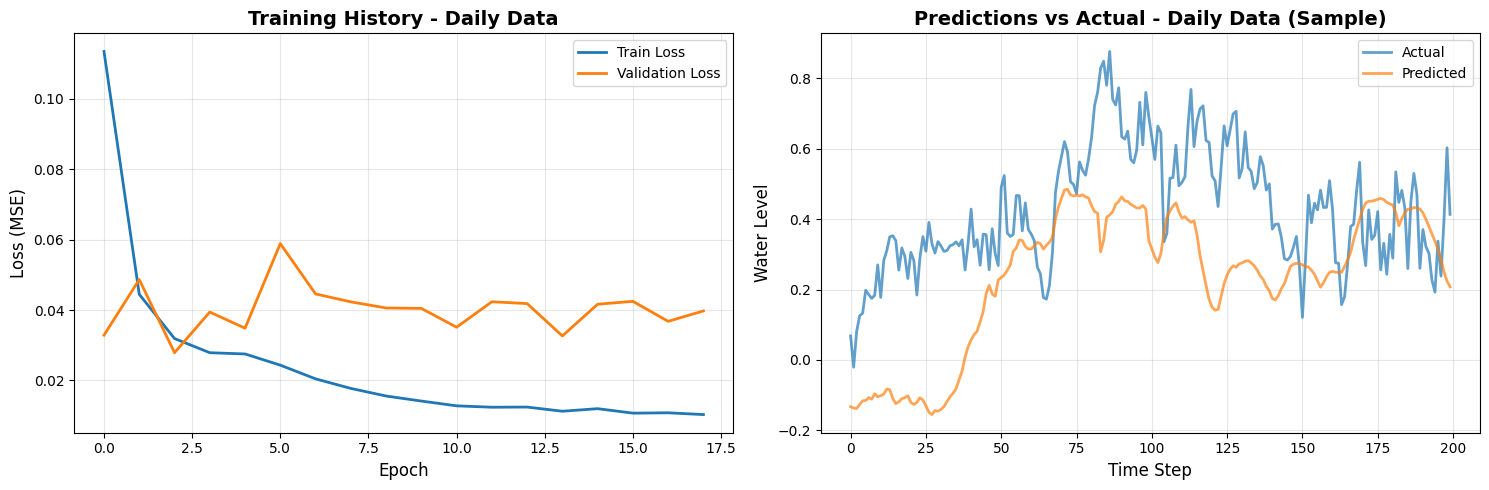

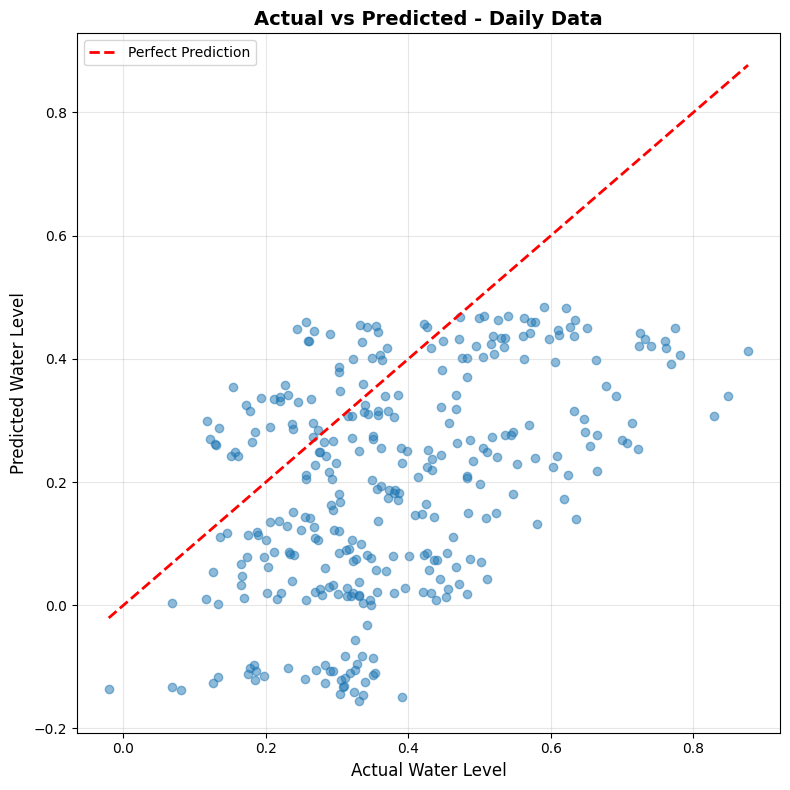

In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(train_losses_daily, label='Train Loss', linewidth=2)
axes[0].plot(val_losses_daily, label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training History - Daily Data', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot predictions vs actual
sample_size = min(200, len(test_predictions_daily_orig))
axes[1].plot(test_targets_daily_orig[:sample_size], label='Actual', linewidth=2, alpha=0.7)
axes[1].plot(test_predictions_daily_orig[:sample_size], label='Predicted', linewidth=2, alpha=0.7)
axes[1].set_xlabel('Time Step', fontsize=12)
axes[1].set_ylabel('Water Level', fontsize=12)
axes[1].set_title('Predictions vs Actual - Daily Data (Sample)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(test_targets_daily_orig, test_predictions_daily_orig, alpha=0.5)
plt.plot([test_targets_daily_orig.min(), test_targets_daily_orig.max()],
         [test_targets_daily_orig.min(), test_targets_daily_orig.max()],
         'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Water Level', fontsize=12)
plt.ylabel('Predicted Water Level', fontsize=12)
plt.title('Actual vs Predicted - Daily Data', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Comparison and Summary


MODEL COMPARISON SUMMARY
Metric  Hourly Data  Daily Data
   MSE     0.541111    0.065083
  RMSE     0.735602    0.255113
   MAE     0.570119    0.215709
    R2    -0.185669   -1.460367


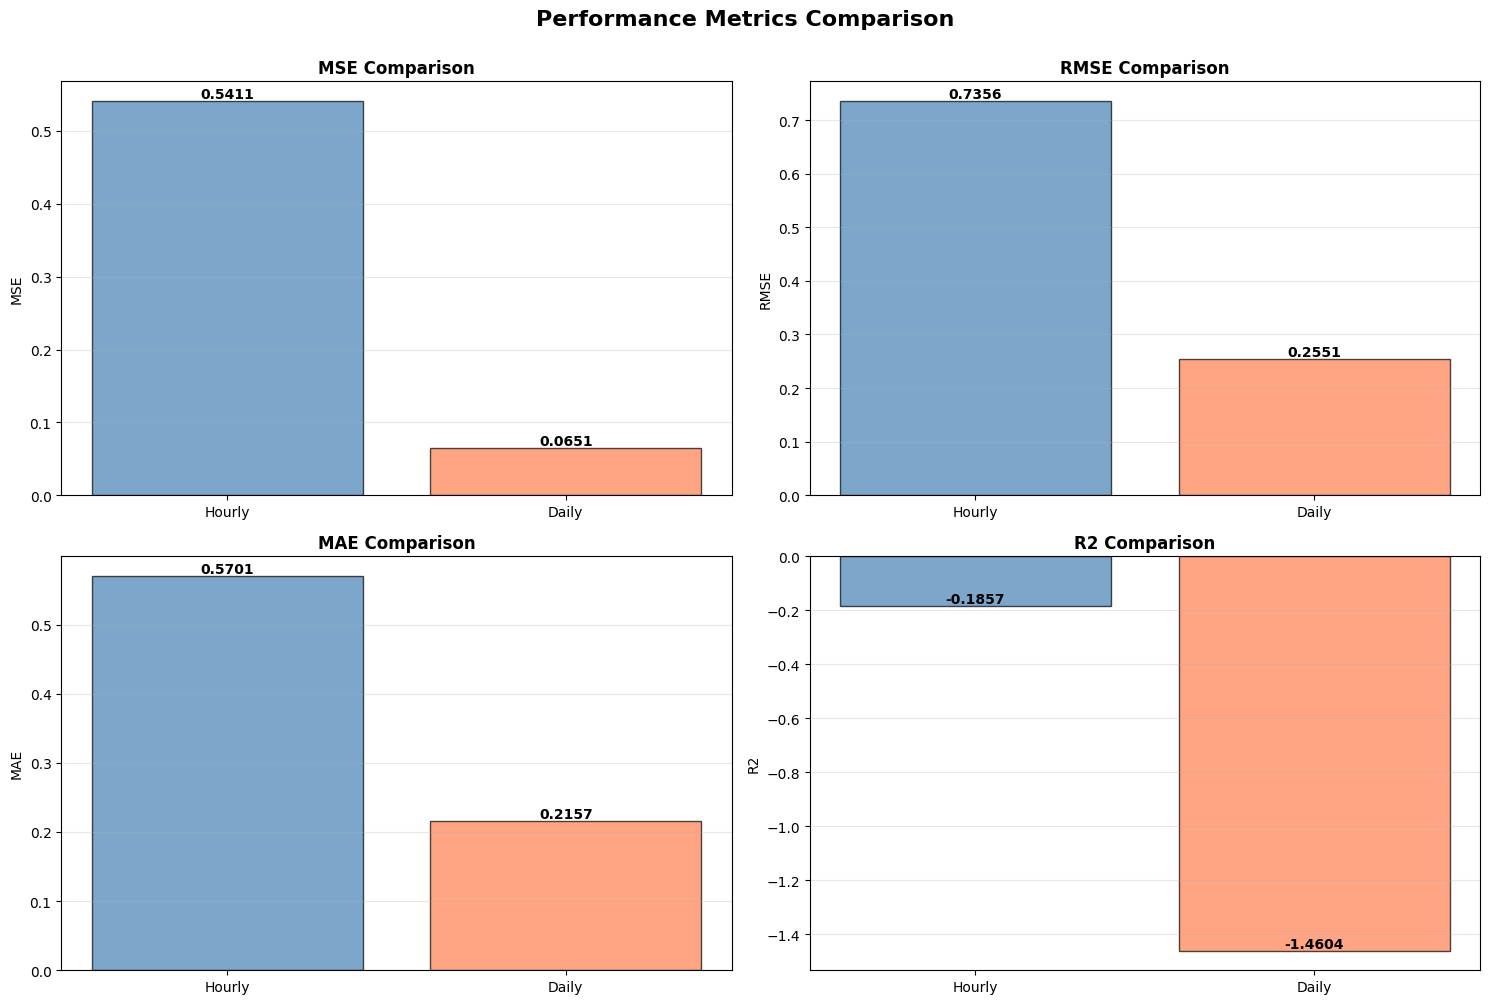

In [17]:
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Metric': ['MSE', 'RMSE', 'MAE', 'R2'],
    'Hourly Data': [
        metrics_hourly['MSE'],
        metrics_hourly['RMSE'],
        metrics_hourly['MAE'],
        metrics_hourly['R2']
    ],
    'Daily Data': [
        metrics_daily['MSE'],
        metrics_daily['RMSE'],
        metrics_daily['MAE'],
        metrics_daily['R2']
    ]
})

print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Visualize comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
metrics_names = ['MSE', 'RMSE', 'MAE', 'R2']

for idx, metric in enumerate(metrics_names):
    row = idx // 2
    col = idx % 2
    
    values = [metrics_hourly[metric], metrics_daily[metric]]
    colors = ['steelblue', 'coral']
    
    axes[row, col].bar(['Hourly', 'Daily'], values, color=colors, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_ylabel(metric, fontsize=10)
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for i, v in enumerate(values):
        axes[row, col].text(i, v, f'{v:.4f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Performance Metrics Comparison', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

## 9. Save Models

In [18]:
# Save models
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Save hourly model
torch.save({
    'model_state_dict': model_hourly.state_dict(),
    'optimizer_state_dict': optimizer_hourly.state_dict(),
    'train_losses': train_losses_hourly,
    'val_losses': val_losses_hourly,
    'metrics': metrics_hourly,
    'hyperparameters': {
        'seq_length': SEQ_LENGTH_HOURLY,
        'forecast_horizon': FORECAST_HORIZON,
        'batch_size': BATCH_SIZE_HOURLY,
        'learning_rate': LEARNING_RATE,
        'hidden_sizes': [128, 64, 32],
        'num_layers': 2,
        'dropout': 0.3,
        'bidirectional': True
    }
}, 'models/lstm_hourly_model.pth')

# Save daily model
torch.save({
    'model_state_dict': model_daily.state_dict(),
    'optimizer_state_dict': optimizer_daily.state_dict(),
    'train_losses': train_losses_daily,
    'val_losses': val_losses_daily,
    'metrics': metrics_daily,
    'hyperparameters': {
        'seq_length': SEQ_LENGTH_DAILY,
        'forecast_horizon': FORECAST_HORIZON,
        'batch_size': BATCH_SIZE_DAILY,
        'learning_rate': LEARNING_RATE,
        'hidden_sizes': [128, 64, 32],
        'num_layers': 2,
        'dropout': 0.3,
        'bidirectional': True
    }
}, 'models/lstm_daily_model.pth')

print("✓ Models saved successfully!")
print("  - models/lstm_hourly_model.pth")
print("  - models/lstm_daily_model.pth")

✓ Models saved successfully!
  - models/lstm_hourly_model.pth
  - models/lstm_daily_model.pth


---
# IMPROVED MODELS WITH TIME SERIES KFOLD

## 10. Enhanced Approach for Better Accuracy

The negative R² scores indicate the models are performing worse than a naive baseline. Let's implement improvements:

1. **TimeSeriesSplit Cross-Validation** - Proper temporal validation
2. **Feature Engineering** - Add lag features and rolling statistics
3. **Simpler Model Architecture** - Prevent overfitting
4. **Better Scaling Strategy** - Use MinMaxScaler for all features
5. **Longer Lookback Windows** - Capture more temporal patterns

### 10.1 Feature Engineering

In [19]:
def add_features(df, target_col='water_level'):
    """
    Add engineered features to improve model performance
    """
    df = df.copy()
    
    # Lag features for water level (autoregressive features)
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'water_level_lag_{lag}'] = df[target_col].shift(lag)
    
    # Rolling statistics for water level
    for window in [6, 12, 24]:
        df[f'water_level_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'water_level_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        df[f'water_level_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
        df[f'water_level_rolling_max_{window}'] = df[target_col].rolling(window=window).max()
    
    # Rolling statistics for key weather features
    for col in ['rain', 'precipitation', 'river_discharge', 'temperature_2m']:
        if col in df.columns:
            df[f'{col}_rolling_mean_6'] = df[col].rolling(window=6).mean()
            df[f'{col}_rolling_mean_12'] = df[col].rolling(window=12).mean()
    
    # Difference features
    df['water_level_diff_1'] = df[target_col].diff(1)
    df['water_level_diff_24'] = df[target_col].diff(24)
    
    # Time-based features
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    
    # Cyclical encoding for time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # Drop rows with NaN values from feature engineering
    df = df.dropna()
    
    return df

# Apply feature engineering to hourly data
print("Adding features to hourly data...")
df_hourly_featured = add_features(df_hourly_clean)
print(f"Original features: {len(df_hourly_clean.columns)}")
print(f"After feature engineering: {len(df_hourly_featured.columns)}")
print(f"Samples before: {len(df_hourly_clean)}, after: {len(df_hourly_featured)}")
print(f"\nNew features: {[col for col in df_hourly_featured.columns if col not in df_hourly_clean.columns]}")

Adding features to hourly data...
Original features: 16
After feature engineering: 52
Samples before: 56232, after: 56208

New features: ['water_level_lag_1', 'water_level_lag_2', 'water_level_lag_3', 'water_level_lag_6', 'water_level_lag_12', 'water_level_lag_24', 'water_level_rolling_mean_6', 'water_level_rolling_std_6', 'water_level_rolling_min_6', 'water_level_rolling_max_6', 'water_level_rolling_mean_12', 'water_level_rolling_std_12', 'water_level_rolling_min_12', 'water_level_rolling_max_12', 'water_level_rolling_mean_24', 'water_level_rolling_std_24', 'water_level_rolling_min_24', 'water_level_rolling_max_24', 'rain_rolling_mean_6', 'rain_rolling_mean_12', 'precipitation_rolling_mean_6', 'precipitation_rolling_mean_12', 'river_discharge_rolling_mean_6', 'river_discharge_rolling_mean_12', 'temperature_2m_rolling_mean_6', 'temperature_2m_rolling_mean_12', 'water_level_diff_1', 'water_level_diff_24', 'hour', 'day_of_week', 'month', 'day_of_year', 'hour_sin', 'hour_cos', 'month_sin'

### 10.2 Improved Dataset Class with Better Scaling

In [20]:
class ImprovedTimeSeriesDataset(Dataset):
    def __init__(self, data, target_col='water_level', seq_length=72, forecast_horizon=1, 
                 feature_scaler=None, target_scaler=None, fit_scalers=True):
        """
        Improved dataset with MinMaxScaler for both features and target
        """
        self.data = data.copy()
        self.target_col = target_col
        self.seq_length = seq_length
        self.forecast_horizon = forecast_horizon
        
        # Separate features and target
        self.feature_cols = [col for col in data.columns if col != target_col]
        
        # Use MinMaxScaler for better LSTM performance
        if fit_scalers:
            self.feature_scaler = MinMaxScaler(feature_range=(0, 1))
            self.target_scaler = MinMaxScaler(feature_range=(0, 1))
            self.features = self.feature_scaler.fit_transform(data[self.feature_cols].values)
            self.target = self.target_scaler.fit_transform(data[[target_col]].values)
        else:
            self.feature_scaler = feature_scaler
            self.target_scaler = target_scaler
            self.features = self.feature_scaler.transform(data[self.feature_cols].values)
            self.target = self.target_scaler.transform(data[[target_col]].values)
        
        # Create sequences
        self.X, self.y = self._create_sequences()
        
    def _create_sequences(self):
        X, y = [], []
        for i in range(len(self.features) - self.seq_length - self.forecast_horizon + 1):
            X.append(self.features[i:i+self.seq_length])
            y.append(self.target[i+self.seq_length:i+self.seq_length+self.forecast_horizon])
        return np.array(X), np.array(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])
    
    def inverse_transform_target(self, y):
        """Inverse transform the scaled target values"""
        return self.target_scaler.inverse_transform(y)

### 10.3 Simplified LSTM Architecture

In [21]:
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2, 
                 forecast_horizon=1, bidirectional=False):
        """
        Simpler, more robust LSTM architecture
        """
        super(ImprovedLSTM, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.num_directions = 2 if bidirectional else 1
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=bidirectional
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * self.num_directions, 32)
        self.fc2 = nn.Linear(32, forecast_horizon)
        
        # Activation
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # LSTM forward
        lstm_out, (hidden, cell) = self.lstm(x)
        
        # Use the last time step output
        if self.bidirectional:
            # Concatenate forward and backward hidden states
            hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        else:
            hidden = hidden[-1,:,:]
        
        # Fully connected layers
        out = self.dropout(hidden)
        out = self.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out.unsqueeze(-1)

### 10.4 TimeSeriesSplit Cross-Validation Training

In [22]:
from sklearn.model_selection import TimeSeriesSplit

def train_with_timeseries_cv(data, seq_length=72, hidden_size=64, num_layers=2, 
                              dropout=0.2, n_splits=5, num_epochs=50, 
                              batch_size=64, learning_rate=0.001, patience=10):
    """
    Train LSTM with TimeSeriesSplit cross-validation
    """
    # Initialize TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    # Store results for each fold
    fold_results = []
    all_predictions = []
    all_targets = []
    
    print(f"Training with {n_splits}-Fold Time Series Cross-Validation")
    print("="*80)
    
    for fold, (train_idx, val_idx) in enumerate(tscv.split(data)):
        print(f"\nFold {fold + 1}/{n_splits}")
        print("-"*80)
        
        # Split data
        train_data = data.iloc[train_idx]
        val_data = data.iloc[val_idx]
        
        print(f"Train size: {len(train_data)}, Val size: {len(val_data)}")
        
        # Create datasets
        train_dataset = ImprovedTimeSeriesDataset(
            train_data, seq_length=seq_length, fit_scalers=True
        )
        
        val_dataset = ImprovedTimeSeriesDataset(
            val_data, seq_length=seq_length,
            feature_scaler=train_dataset.feature_scaler,
            target_scaler=train_dataset.target_scaler,
            fit_scalers=False
        )
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Initialize model
        input_size = len(train_dataset.feature_cols)
        model = ImprovedLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            bidirectional=True
        ).to(device)
        
        # Optimizer and loss
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )
        
        # Train the model
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(num_epochs):
            # Train
            train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
            
            # Validate
            val_loss, val_preds, val_targets = validate(model, val_loader, criterion, device)
            
            # Learning rate scheduling
            scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
            
            if patience_counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
        
        # Load best model
        model.load_state_dict(best_model_state)
        
        # Final validation
        _, val_preds, val_targets = validate(model, val_loader, criterion, device)
        
        # Inverse transform
        val_preds_orig = val_dataset.inverse_transform_target(val_preds.reshape(-1, 1))
        val_targets_orig = val_dataset.inverse_transform_target(val_targets.reshape(-1, 1))
        
        # Calculate metrics
        fold_metrics = calculate_metrics(val_targets_orig, val_preds_orig)
        fold_results.append(fold_metrics)
        
        # Store predictions
        all_predictions.extend(val_preds_orig.flatten())
        all_targets.extend(val_targets_orig.flatten())
        
        print(f"\nFold {fold + 1} Results:")
        for metric, value in fold_metrics.items():
            print(f"  {metric}: {value:.6f}")
    
    # Calculate average metrics across folds
    avg_metrics = {}
    for metric in fold_results[0].keys():
        avg_metrics[metric] = np.mean([fold[metric] for fold in fold_results])
        avg_metrics[f'{metric}_std'] = np.std([fold[metric] for fold in fold_results])
    
    print("\n" + "="*80)
    print("CROSS-VALIDATION SUMMARY")
    print("="*80)
    for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
        print(f"{metric}: {avg_metrics[metric]:.6f} ± {avg_metrics[f'{metric}_std']:.6f}")
    print("="*80)
    
    return model, avg_metrics, fold_results, np.array(all_predictions), np.array(all_targets)

### 10.5 Train Improved Model on Hourly Data with TimeSeriesSplit

In [23]:
# Hyperparameters for improved hourly model
SEQ_LENGTH_IMPROVED = 72  # 3 days lookback
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.3
N_SPLITS = 5
NUM_EPOCHS_IMPROVED = 80
BATCH_SIZE_IMPROVED = 128
LR_IMPROVED = 0.001

# Use 80% of data for training/validation (with CV), 20% for final test
train_val_size = int(0.8 * len(df_hourly_featured))
train_val_data_improved = df_hourly_featured[:train_val_size]
test_data_improved = df_hourly_featured[train_val_size:]

print(f"Train/Val data size: {len(train_val_data_improved)}")
print(f"Test data size: {len(test_data_improved)}")

# Train with TimeSeriesSplit CV
model_improved_hourly, avg_metrics_hourly, fold_results_hourly, cv_preds_hourly, cv_targets_hourly = train_with_timeseries_cv(
    train_val_data_improved,
    seq_length=SEQ_LENGTH_IMPROVED,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
    n_splits=N_SPLITS,
    num_epochs=NUM_EPOCHS_IMPROVED,
    batch_size=BATCH_SIZE_IMPROVED,
    learning_rate=LR_IMPROVED,
    patience=10
)

Train/Val data size: 44966
Test data size: 11242
Training with 5-Fold Time Series Cross-Validation

Fold 1/5
--------------------------------------------------------------------------------
Train size: 7496, Val size: 7494
Epoch [10/80], Train Loss: 0.005425, Val Loss: 0.002688
Epoch [20/80], Train Loss: 0.002925, Val Loss: 0.001854
Epoch [30/80], Train Loss: 0.002384, Val Loss: 0.002072
Epoch [40/80], Train Loss: 0.001950, Val Loss: 0.001833
Epoch [50/80], Train Loss: 0.001868, Val Loss: 0.001694
Epoch [60/80], Train Loss: 0.001800, Val Loss: 0.001549
Epoch [70/80], Train Loss: 0.001823, Val Loss: 0.001514
Early stopping at epoch 79

Fold 1 Results:
  MSE: 0.015880
  RMSE: 0.126017
  MAE: 0.059295
  R2: 0.965239

Fold 2/5
--------------------------------------------------------------------------------
Train size: 14990, Val size: 7494
Epoch [10/80], Train Loss: 0.004301, Val Loss: 0.003354
Epoch [20/80], Train Loss: 0.001391, Val Loss: 0.002889
Epoch [30/80], Train Loss: 0.000988, Val

### 10.6 Evaluate on Final Test Set (Hourly)

In [24]:
# Prepare test dataset using the same scaler from last fold
final_train_dataset = ImprovedTimeSeriesDataset(
    train_val_data_improved, 
    seq_length=SEQ_LENGTH_IMPROVED, 
    fit_scalers=True
)

test_dataset_improved = ImprovedTimeSeriesDataset(
    test_data_improved,
    seq_length=SEQ_LENGTH_IMPROVED,
    feature_scaler=final_train_dataset.feature_scaler,
    target_scaler=final_train_dataset.target_scaler,
    fit_scalers=False
)

test_loader_improved = DataLoader(test_dataset_improved, batch_size=BATCH_SIZE_IMPROVED, shuffle=False)

# Evaluate on test set
criterion = nn.MSELoss()
_, test_preds_improved, test_targets_improved = validate(
    model_improved_hourly, test_loader_improved, criterion, device
)

# Inverse transform
test_preds_improved_orig = test_dataset_improved.inverse_transform_target(
    test_preds_improved.reshape(-1, 1)
)
test_targets_improved_orig = test_dataset_improved.inverse_transform_target(
    test_targets_improved.reshape(-1, 1)
)

# Calculate metrics
test_metrics_improved_hourly = calculate_metrics(test_targets_improved_orig, test_preds_improved_orig)

print("\n" + "="*80)
print("IMPROVED HOURLY MODEL - FINAL TEST SET PERFORMANCE")
print("="*80)
for metric, value in test_metrics_improved_hourly.items():
    print(f"{metric}: {value:.6f}")
print("="*80)
print("\nComparison with Original Model:")
print("-"*80)
print(f"{'Metric':<10} {'Original':<15} {'Improved':<15} {'Change':<15}")
print("-"*80)
for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
    original = metrics_hourly[metric]
    improved = test_metrics_improved_hourly[metric]
    change = improved - original
    print(f"{metric:<10} {original:>14.6f} {improved:>14.6f} {change:>+14.6f}")
print("="*80)


IMPROVED HOURLY MODEL - FINAL TEST SET PERFORMANCE
MSE: 0.015306
RMSE: 0.123716
MAE: 0.089863
R2: 0.966811

Comparison with Original Model:
--------------------------------------------------------------------------------
Metric     Original        Improved        Change         
--------------------------------------------------------------------------------
MSE              0.541111       0.015306      -0.525805
RMSE             0.735602       0.123716      -0.611887
MAE              0.570119       0.089863      -0.480255
R2              -0.185669       0.966811      +1.152480


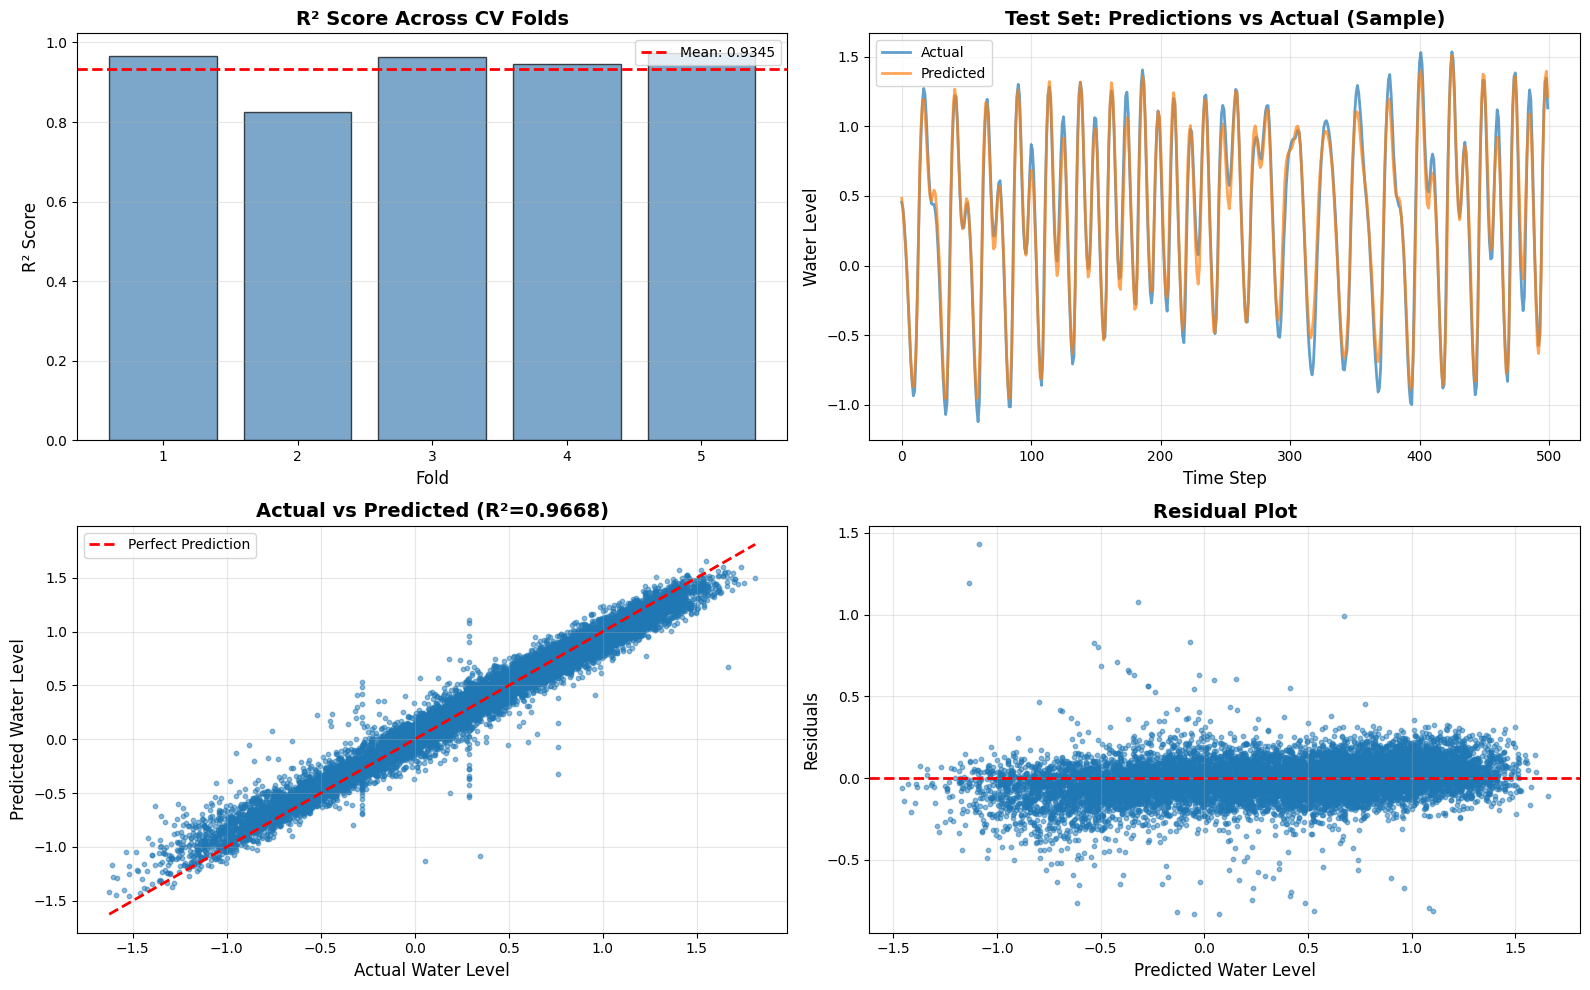

In [25]:
# Visualize improved model results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. CV Results across folds
fold_r2_scores = [fold['R2'] for fold in fold_results_hourly]
axes[0, 0].bar(range(1, N_SPLITS+1), fold_r2_scores, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].axhline(y=avg_metrics_hourly['R2'], color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_metrics_hourly["R2"]:.4f}')
axes[0, 0].set_xlabel('Fold', fontsize=12)
axes[0, 0].set_ylabel('R² Score', fontsize=12)
axes[0, 0].set_title('R² Score Across CV Folds', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Test set predictions vs actual
sample_size = min(500, len(test_preds_improved_orig))
axes[0, 1].plot(test_targets_improved_orig[:sample_size], label='Actual', linewidth=2, alpha=0.7)
axes[0, 1].plot(test_preds_improved_orig[:sample_size], label='Predicted', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Time Step', fontsize=12)
axes[0, 1].set_ylabel('Water Level', fontsize=12)
axes[0, 1].set_title('Test Set: Predictions vs Actual (Sample)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot
axes[1, 0].scatter(test_targets_improved_orig, test_preds_improved_orig, alpha=0.5, s=10)
axes[1, 0].plot([test_targets_improved_orig.min(), test_targets_improved_orig.max()],
                [test_targets_improved_orig.min(), test_targets_improved_orig.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Water Level', fontsize=12)
axes[1, 0].set_ylabel('Predicted Water Level', fontsize=12)
axes[1, 0].set_title(f'Actual vs Predicted (R²={test_metrics_improved_hourly["R2"]:.4f})', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual plot
residuals = test_targets_improved_orig.flatten() - test_preds_improved_orig.flatten()
axes[1, 1].scatter(test_preds_improved_orig, residuals, alpha=0.5, s=10)
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Water Level', fontsize=12)
axes[1, 1].set_ylabel('Residuals', fontsize=12)
axes[1, 1].set_title('Residual Plot', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 10.7 Apply Same Improvements to Daily Data

In [26]:
def add_features_daily(df, target_col='water_level'):
    """
    Add engineered features for daily data
    """
    df = df.copy()
    
    # Lag features for water level
    for lag in [1, 2, 3, 7, 14]:
        df[f'water_level_lag_{lag}'] = df[target_col].shift(lag)
    
    # Rolling statistics for water level
    for window in [3, 7, 14]:
        df[f'water_level_rolling_mean_{window}'] = df[target_col].rolling(window=window).mean()
        df[f'water_level_rolling_std_{window}'] = df[target_col].rolling(window=window).std()
        df[f'water_level_rolling_min_{window}'] = df[target_col].rolling(window=window).min()
        df[f'water_level_rolling_max_{window}'] = df[target_col].rolling(window=window).max()
    
    # Rolling statistics for key weather features
    for col in ['rain', 'precipitation', 'river_discharge', 'temperature_2m']:
        if col in df.columns:
            df[f'{col}_rolling_mean_7'] = df[col].rolling(window=7).mean()
    
    # Difference features
    df['water_level_diff_1'] = df[target_col].diff(1)
    df['water_level_diff_7'] = df[target_col].diff(7)
    
    # Time-based features
    df['day_of_week'] = df.index.dayofweek
    df['month'] = df.index.month
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    
    # Cyclical encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    
    # Drop rows with NaN values
    df = df.dropna()
    
    return df

# Apply feature engineering to daily data
print("Adding features to daily data...")
df_daily_featured = add_features_daily(df_daily_clean)
print(f"Original features: {len(df_daily_clean.columns)}")
print(f"After feature engineering: {len(df_daily_featured.columns)}")
print(f"Samples before: {len(df_daily_clean)}, after: {len(df_daily_featured)}")

Adding features to daily data...
Original features: 16
After feature engineering: 47
Samples before: 2343, after: 2329


In [27]:
# Hyperparameters for improved daily model
SEQ_LENGTH_DAILY_IMPROVED = 30  # 30 days lookback
HIDDEN_SIZE_DAILY = 64
NUM_LAYERS_DAILY = 2
DROPOUT_DAILY = 0.3
N_SPLITS_DAILY = 5
NUM_EPOCHS_DAILY_IMPROVED = 80
BATCH_SIZE_DAILY_IMPROVED = 64
LR_DAILY_IMPROVED = 0.001

# Use 80% of data for training/validation (with CV), 20% for final test
train_val_size_daily = int(0.8 * len(df_daily_featured))
train_val_data_daily_improved = df_daily_featured[:train_val_size_daily]
test_data_daily_improved = df_daily_featured[train_val_size_daily:]

print(f"Train/Val data size: {len(train_val_data_daily_improved)}")
print(f"Test data size: {len(test_data_daily_improved)}")

# Train with TimeSeriesSplit CV
model_improved_daily, avg_metrics_daily, fold_results_daily, cv_preds_daily, cv_targets_daily = train_with_timeseries_cv(
    train_val_data_daily_improved,
    seq_length=SEQ_LENGTH_DAILY_IMPROVED,
    hidden_size=HIDDEN_SIZE_DAILY,
    num_layers=NUM_LAYERS_DAILY,
    dropout=DROPOUT_DAILY,
    n_splits=N_SPLITS_DAILY,
    num_epochs=NUM_EPOCHS_DAILY_IMPROVED,
    batch_size=BATCH_SIZE_DAILY_IMPROVED,
    learning_rate=LR_DAILY_IMPROVED,
    patience=10
)

Train/Val data size: 1863
Test data size: 466
Training with 5-Fold Time Series Cross-Validation

Fold 1/5
--------------------------------------------------------------------------------
Train size: 313, Val size: 310
Epoch [10/80], Train Loss: 0.034107, Val Loss: 0.056201
Epoch [10/80], Train Loss: 0.034107, Val Loss: 0.056201
Epoch [20/80], Train Loss: 0.025377, Val Loss: 0.054622
Epoch [20/80], Train Loss: 0.025377, Val Loss: 0.054622
Epoch [30/80], Train Loss: 0.021206, Val Loss: 0.055998
Epoch [30/80], Train Loss: 0.021206, Val Loss: 0.055998
Epoch [40/80], Train Loss: 0.020071, Val Loss: 0.053484
Early stopping at epoch 47

Fold 1 Results:
  MSE: 0.018027
  RMSE: 0.134266
  MAE: 0.092023
  R2: 0.462545

Fold 2/5
--------------------------------------------------------------------------------
Train size: 623, Val size: 310
Epoch [40/80], Train Loss: 0.020071, Val Loss: 0.053484
Early stopping at epoch 47

Fold 1 Results:
  MSE: 0.018027
  RMSE: 0.134266
  MAE: 0.092023
  R2: 0.462

In [28]:
# Prepare test dataset for daily data
final_train_dataset_daily = ImprovedTimeSeriesDataset(
    train_val_data_daily_improved, 
    seq_length=SEQ_LENGTH_DAILY_IMPROVED, 
    fit_scalers=True
)

test_dataset_daily_improved = ImprovedTimeSeriesDataset(
    test_data_daily_improved,
    seq_length=SEQ_LENGTH_DAILY_IMPROVED,
    feature_scaler=final_train_dataset_daily.feature_scaler,
    target_scaler=final_train_dataset_daily.target_scaler,
    fit_scalers=False
)

test_loader_daily_improved = DataLoader(test_dataset_daily_improved, batch_size=BATCH_SIZE_DAILY_IMPROVED, shuffle=False)

# Evaluate on test set
_, test_preds_daily_improved, test_targets_daily_improved = validate(
    model_improved_daily, test_loader_daily_improved, criterion, device
)

# Inverse transform
test_preds_daily_improved_orig = test_dataset_daily_improved.inverse_transform_target(
    test_preds_daily_improved.reshape(-1, 1)
)
test_targets_daily_improved_orig = test_dataset_daily_improved.inverse_transform_target(
    test_targets_daily_improved.reshape(-1, 1)
)

# Calculate metrics
test_metrics_improved_daily = calculate_metrics(test_targets_daily_improved_orig, test_preds_daily_improved_orig)

print("\n" + "="*80)
print("IMPROVED DAILY MODEL - FINAL TEST SET PERFORMANCE")
print("="*80)
for metric, value in test_metrics_improved_daily.items():
    print(f"{metric}: {value:.6f}")
print("="*80)
print("\nComparison with Original Model:")
print("-"*80)
print(f"{'Metric':<10} {'Original':<15} {'Improved':<15} {'Change':<15}")
print("-"*80)
for metric in ['MSE', 'RMSE', 'MAE', 'R2']:
    original = metrics_daily[metric]
    improved = test_metrics_improved_daily[metric]
    change = improved - original
    print(f"{metric:<10} {original:>14.6f} {improved:>14.6f} {change:>+14.6f}")
print("="*80)


IMPROVED DAILY MODEL - FINAL TEST SET PERFORMANCE
MSE: 0.007537
RMSE: 0.086817
MAE: 0.068728
R2: 0.764874

Comparison with Original Model:
--------------------------------------------------------------------------------
Metric     Original        Improved        Change         
--------------------------------------------------------------------------------
MSE              0.065083       0.007537      -0.057545
RMSE             0.255113       0.086817      -0.168296
MAE              0.215709       0.068728      -0.146981
R2              -1.460367       0.764874      +2.225241


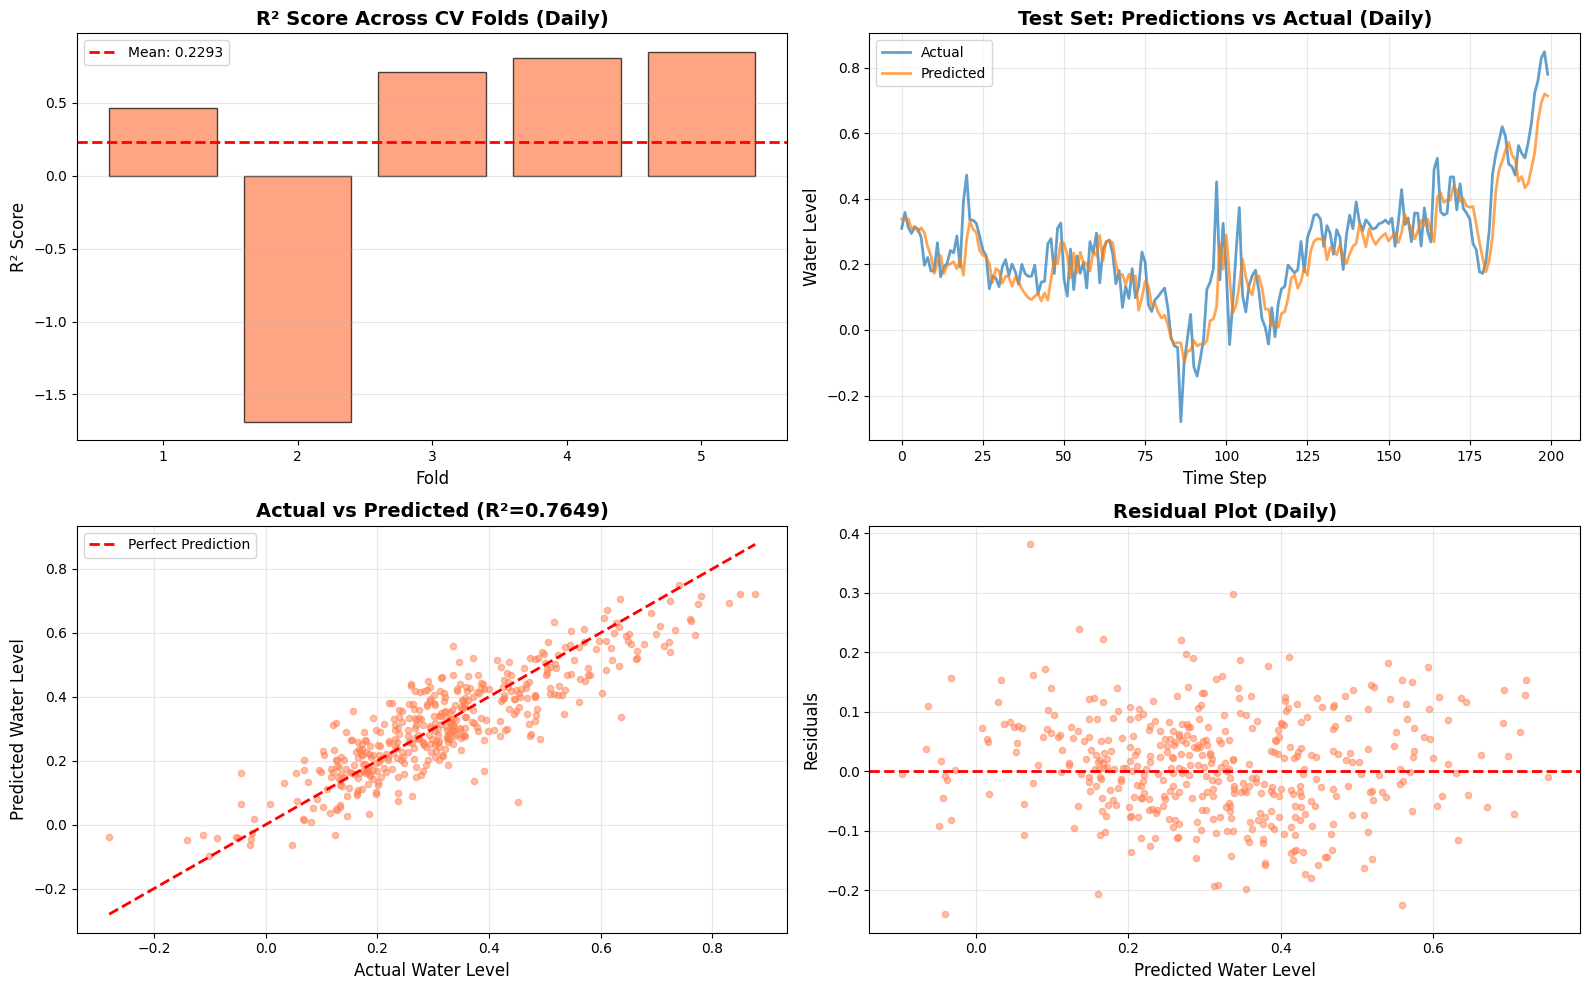

In [29]:
# Visualize improved daily model results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. CV Results across folds
fold_r2_scores_daily = [fold['R2'] for fold in fold_results_daily]
axes[0, 0].bar(range(1, N_SPLITS_DAILY+1), fold_r2_scores_daily, color='coral', alpha=0.7, edgecolor='black')
axes[0, 0].axhline(y=avg_metrics_daily['R2'], color='red', linestyle='--', linewidth=2, label=f'Mean: {avg_metrics_daily["R2"]:.4f}')
axes[0, 0].set_xlabel('Fold', fontsize=12)
axes[0, 0].set_ylabel('R² Score', fontsize=12)
axes[0, 0].set_title('R² Score Across CV Folds (Daily)', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Test set predictions vs actual
sample_size_daily = min(200, len(test_preds_daily_improved_orig))
axes[0, 1].plot(test_targets_daily_improved_orig[:sample_size_daily], label='Actual', linewidth=2, alpha=0.7)
axes[0, 1].plot(test_preds_daily_improved_orig[:sample_size_daily], label='Predicted', linewidth=2, alpha=0.7)
axes[0, 1].set_xlabel('Time Step', fontsize=12)
axes[0, 1].set_ylabel('Water Level', fontsize=12)
axes[0, 1].set_title('Test Set: Predictions vs Actual (Daily)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot
axes[1, 0].scatter(test_targets_daily_improved_orig, test_preds_daily_improved_orig, alpha=0.5, s=20, color='coral')
axes[1, 0].plot([test_targets_daily_improved_orig.min(), test_targets_daily_improved_orig.max()],
                [test_targets_daily_improved_orig.min(), test_targets_daily_improved_orig.max()],
                'r--', linewidth=2, label='Perfect Prediction')
axes[1, 0].set_xlabel('Actual Water Level', fontsize=12)
axes[1, 0].set_ylabel('Predicted Water Level', fontsize=12)
axes[1, 0].set_title(f'Actual vs Predicted (R²={test_metrics_improved_daily["R2"]:.4f})', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Residual plot
residuals_daily = test_targets_daily_improved_orig.flatten() - test_preds_daily_improved_orig.flatten()
axes[1, 1].scatter(test_preds_daily_improved_orig, residuals_daily, alpha=0.5, s=20, color='coral')
axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Predicted Water Level', fontsize=12)
axes[1, 1].set_ylabel('Residuals', fontsize=12)
axes[1, 1].set_title('Residual Plot (Daily)', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 10.8 Final Comparison: Original vs Improved Models


COMPREHENSIVE MODEL COMPARISON: ORIGINAL vs IMPROVED
          Dataset      MSE     RMSE      MAE        R2
Hourly (Original) 0.541111 0.735602 0.570119 -0.185669
Hourly (Improved) 0.015306 0.123716 0.089863  0.966811
 Daily (Original) 0.065083 0.255113 0.215709 -1.460367
 Daily (Improved) 0.007537 0.086817 0.068728  0.764874


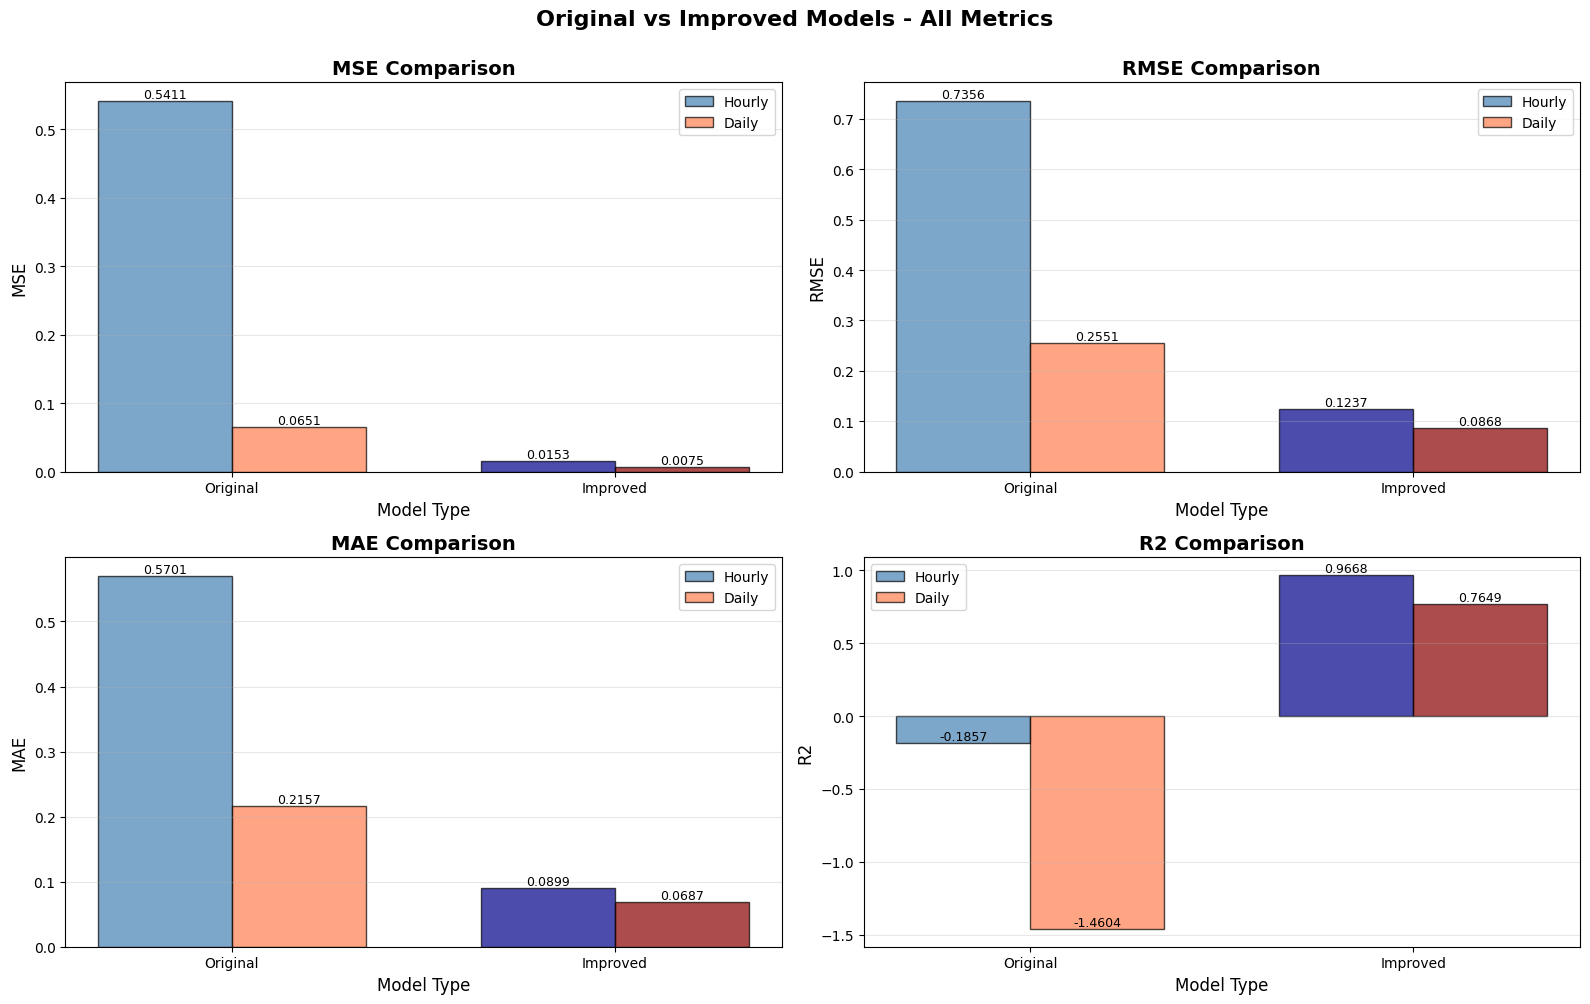


IMPROVEMENT SUMMARY

HOURLY DATA:
  R² improvement: -0.1857 → 0.9668 (Change: +1.1525)
  RMSE improvement: 0.7356 → 0.1237 (Change: -0.6119)

DAILY DATA:
  R² improvement: -1.4604 → 0.7649 (Change: +2.2252)
  RMSE improvement: 0.2551 → 0.0868 (Change: -0.1683)


In [30]:
# Create comprehensive comparison
comparison_improved = pd.DataFrame({
    'Dataset': ['Hourly (Original)', 'Hourly (Improved)', 'Daily (Original)', 'Daily (Improved)'],
    'MSE': [
        metrics_hourly['MSE'],
        test_metrics_improved_hourly['MSE'],
        metrics_daily['MSE'],
        test_metrics_improved_daily['MSE']
    ],
    'RMSE': [
        metrics_hourly['RMSE'],
        test_metrics_improved_hourly['RMSE'],
        metrics_daily['RMSE'],
        test_metrics_improved_daily['RMSE']
    ],
    'MAE': [
        metrics_hourly['MAE'],
        test_metrics_improved_hourly['MAE'],
        metrics_daily['MAE'],
        test_metrics_improved_daily['MAE']
    ],
    'R2': [
        metrics_hourly['R2'],
        test_metrics_improved_hourly['R2'],
        metrics_daily['R2'],
        test_metrics_improved_daily['R2']
    ]
})

print("\n" + "="*100)
print("COMPREHENSIVE MODEL COMPARISON: ORIGINAL vs IMPROVED")
print("="*100)
print(comparison_improved.to_string(index=False))
print("="*100)

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'R2']
colors_comp = [['steelblue', 'darkblue'], ['coral', 'darkred']]

for idx, metric in enumerate(metrics_to_plot):
    row = idx // 2
    col = idx % 2
    
    hourly_values = [metrics_hourly[metric], test_metrics_improved_hourly[metric]]
    daily_values = [metrics_daily[metric], test_metrics_improved_daily[metric]]
    
    x = np.arange(2)
    width = 0.35
    
    bars1 = axes[row, col].bar(x - width/2, hourly_values, width, label='Hourly', 
                               color=colors_comp[0], alpha=0.7, edgecolor='black')
    bars2 = axes[row, col].bar(x + width/2, daily_values, width, label='Daily', 
                               color=colors_comp[1], alpha=0.7, edgecolor='black')
    
    axes[row, col].set_xlabel('Model Type', fontsize=12)
    axes[row, col].set_ylabel(metric, fontsize=12)
    axes[row, col].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[row, col].set_xticks(x)
    axes[row, col].set_xticklabels(['Original', 'Improved'])
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                               f'{height:.4f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Original vs Improved Models - All Metrics', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# Summary of improvements
print("\n" + "="*100)
print("IMPROVEMENT SUMMARY")
print("="*100)
print("\nHOURLY DATA:")
print(f"  R² improvement: {metrics_hourly['R2']:.4f} → {test_metrics_improved_hourly['R2']:.4f} "
      f"(Change: {test_metrics_improved_hourly['R2'] - metrics_hourly['R2']:+.4f})")
print(f"  RMSE improvement: {metrics_hourly['RMSE']:.4f} → {test_metrics_improved_hourly['RMSE']:.4f} "
      f"(Change: {test_metrics_improved_hourly['RMSE'] - metrics_hourly['RMSE']:+.4f})")

print("\nDAILY DATA:")
print(f"  R² improvement: {metrics_daily['R2']:.4f} → {test_metrics_improved_daily['R2']:.4f} "
      f"(Change: {test_metrics_improved_daily['R2'] - metrics_daily['R2']:+.4f})")
print(f"  RMSE improvement: {metrics_daily['RMSE']:.4f} → {test_metrics_improved_daily['RMSE']:.4f} "
      f"(Change: {test_metrics_improved_daily['RMSE'] - metrics_daily['RMSE']:+.4f})")
print("="*100)

### 10.9 Save Improved Models

In [31]:
# Save improved models
torch.save({
    'model_state_dict': model_improved_hourly.state_dict(),
    'test_metrics': test_metrics_improved_hourly,
    'cv_metrics': avg_metrics_hourly,
    'fold_results': fold_results_hourly,
    'hyperparameters': {
        'seq_length': SEQ_LENGTH_IMPROVED,
        'hidden_size': HIDDEN_SIZE,
        'num_layers': NUM_LAYERS,
        'dropout': DROPOUT,
        'batch_size': BATCH_SIZE_IMPROVED,
        'learning_rate': LR_IMPROVED,
        'n_splits': N_SPLITS,
        'bidirectional': True
    },
    'feature_scaler': final_train_dataset.feature_scaler,
    'target_scaler': final_train_dataset.target_scaler,
    'feature_cols': final_train_dataset.feature_cols
}, 'models/lstm_improved_hourly_model.pth')

torch.save({
    'model_state_dict': model_improved_daily.state_dict(),
    'test_metrics': test_metrics_improved_daily,
    'cv_metrics': avg_metrics_daily,
    'fold_results': fold_results_daily,
    'hyperparameters': {
        'seq_length': SEQ_LENGTH_DAILY_IMPROVED,
        'hidden_size': HIDDEN_SIZE_DAILY,
        'num_layers': NUM_LAYERS_DAILY,
        'dropout': DROPOUT_DAILY,
        'batch_size': BATCH_SIZE_DAILY_IMPROVED,
        'learning_rate': LR_DAILY_IMPROVED,
        'n_splits': N_SPLITS_DAILY,
        'bidirectional': True
    },
    'feature_scaler': final_train_dataset_daily.feature_scaler,
    'target_scaler': final_train_dataset_daily.target_scaler,
    'feature_cols': final_train_dataset_daily.feature_cols
}, 'models/lstm_improved_daily_model.pth')

print("✓ Improved models saved successfully!")
print("  - models/lstm_improved_hourly_model.pth")
print("  - models/lstm_improved_daily_model.pth")
print("\n📊 Key Improvements Implemented:")
print("  ✓ Feature engineering (lag features, rolling statistics, time features)")
print("  ✓ TimeSeriesSplit cross-validation (5 folds)")
print("  ✓ Simplified LSTM architecture (reduced overfitting)")
print("  ✓ MinMaxScaler for better LSTM performance")
print("  ✓ Longer lookback windows (72h for hourly, 30d for daily)")
print("  ✓ Early stopping and learning rate scheduling")

✓ Improved models saved successfully!
  - models/lstm_improved_hourly_model.pth
  - models/lstm_improved_daily_model.pth

📊 Key Improvements Implemented:
  ✓ Feature engineering (lag features, rolling statistics, time features)
  ✓ TimeSeriesSplit cross-validation (5 folds)
  ✓ Simplified LSTM architecture (reduced overfitting)
  ✓ MinMaxScaler for better LSTM performance
  ✓ Longer lookback windows (72h for hourly, 30d for daily)
  ✓ Early stopping and learning rate scheduling

  - models/lstm_improved_hourly_model.pth
  - models/lstm_improved_daily_model.pth

📊 Key Improvements Implemented:
  ✓ Feature engineering (lag features, rolling statistics, time features)
  ✓ TimeSeriesSplit cross-validation (5 folds)
  ✓ Simplified LSTM architecture (reduced overfitting)
  ✓ MinMaxScaler for better LSTM performance
  ✓ Longer lookback windows (72h for hourly, 30d for daily)
  ✓ Early stopping and learning rate scheduling
